# Introduction

This requires that you have a `servicex` instance running as a datasource on local ports 5000 and 9000. Below is a very general introduction starting out simple and building in this page and later pages.

In [1]:
import sys
sys.path = ['..'] + sys.path
from hep_tables import xaod_table,make_local
from func_adl import EventDataset
import matplotlib.pyplot as plt

plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})

Everything has to start from a dataset.

In [2]:
dataset = EventDataset('localds://mc15_13TeV:mc15_13TeV.361106.PowhegPythia8EvtGen_AZNLOCTEQ6L1_Zee.merge.DAOD_STDM3.e3601_s2576_s2132_r6630_r6264_p2363_tid05630052_00')

And we need to frame this as a hierarchical `DataFrame`. This implies some knowledge of how to translate it into columns, so here we need indicate that this is a dataset with ATLAS `xAOD` files in it.

In [3]:
df = xaod_table(dataset)

# Plotting hierarchical data

First, lets just get all the $p_T$'s of electrons from our data sample. Note that in ATLAS units are in `MeV`, but `GeV` just makes more sense. So divide the jet pt's by 1000.

In [4]:
%%time
pts = df.Electrons("Electrons").pt/1000.0

Wall time: 0 ns


We just have the DAG for extracting the $p_T$'s of all electrons in this dataset. If we want to plot it, we have to materalize it and bring the data local. Then we can plot it.

In [5]:
%%time
np_pts = make_local(pts)

Wall time: 4min 30s


The above cell did the following things:

1. Translated the DAQ into a data-query expression for `servicex`
1. Sent the query to `servicex`. `servicex` ran on 17 files that are in the $Z\rightarrow ee$ dataset, and collected their results. The package then downloaded the results locally.
1. Wrapped up the results as an in-memory JaggedArray.

i:\gwatts\code\irishep\hep_tables\.venv\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
i:\gwatts\code\irishep\hep_tables\.venv\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


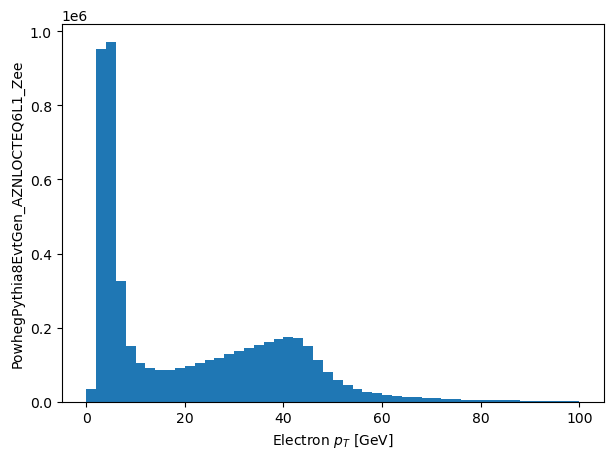

In [6]:
plt.hist(np_pts.flatten(), range=(0, 100), bins=50)
plt.xlabel('Electron $p_T$ [GeV]')
_ = plt.ylabel('PowhegPythia8EvtGen_AZNLOCTEQ6L1_Zee')

The data that comes back is a very simple `JaggedArray` - this is from the `awkward` array package. So you can manipulate it as you would wish. It should be noted that it isn't clear than you can do this in Run 4 of the LHC - even this data may be too big to efficiently move between front ends adn back-ends. But for now, the data is nice and small!

In [7]:
print (type(np_pts))
print (len(np_pts))
np_pts

<class 'awkward.array.jagged.JaggedArray'>
1993800


<JaggedArray [[28.004091796875 6.10038916015625] [45.704671875 43.7033984375 6.64995751953125 5.02277734375 2.998830078125] [24.03434765625 3.9919736328125 5.807431640625 2.8139931640625] ... [36.46915625 25.50325 13.456806640625 ... 4.27271728515625 4.17789990234375 3.15295556640625] [43.63255859375 39.20566796875 3.786251953125] [39.07298828125 43.704296875 3.854654541015625 3.91102734375]] at 0x02cc3fee3908>

## Filtering

What if we only want to look at the electrons with a $p_T$ above 50 GeV? Then we use the slice operations that `numpy` and `pandas` have gotten us used to. To avoid repeating ourselves and typing long lines, it is convienient to define a few variables as short-cuts. We also want a list of _good electrons_, so lets define that.

In [8]:
%%time
eles = df.Electrons("Electrons")
good_eles = eles[(eles.pt > 50000.0) & (abs(eles.eta) < 1.5)]

np_pts_good_short = make_local(good_eles.pt/1000.0)

Wall time: 1min 32s


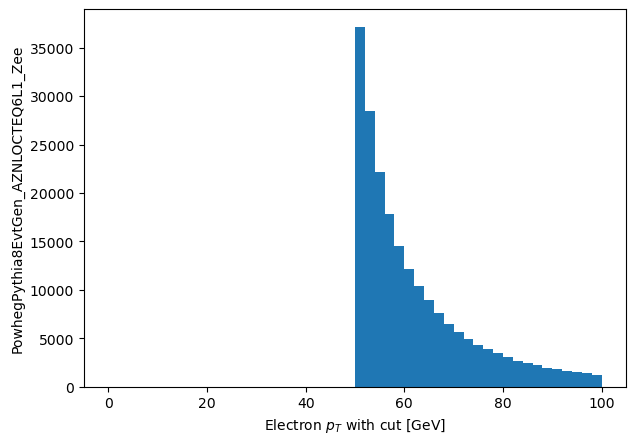

In [9]:
plt.hist(np_pts_good_short.flatten(), range=(0, 100), bins=50)
plt.xlabel('Electron $p_T$ with cut [GeV]')
_ = plt.ylabel('PowhegPythia8EvtGen_AZNLOCTEQ6L1_Zee')

So now we can look at the $\eta$ distributions before and after that cut if we like. Note we move the lists right inside the `make_local` call as we aren't going to really need those definitions elsewhere.

In [10]:
%%time
np_eta_all = make_local(eles.eta)
np_eta_good = make_local(good_eles.eta)

Wall time: 3min 30s


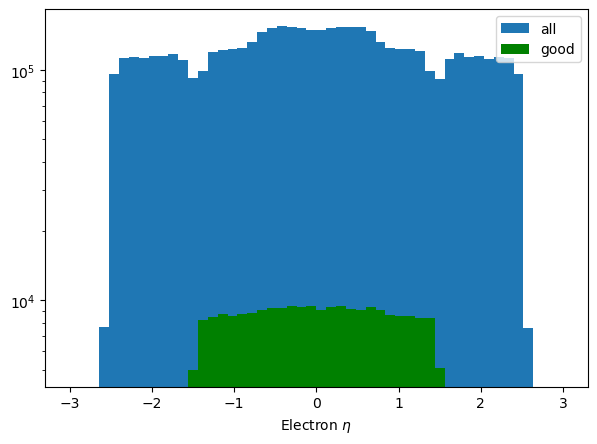

In [11]:
plt.hist(np_eta_all.flatten(), label='all', bins=50, range=(-3.0,3.0))
plt.hist(np_eta_good.flatten(), label='good', bins=50, range=(-3.0,3.0), color='g')
plt.yscale('log')
plt.xlabel('Electron $\eta$')
plt.legend();

### Filter Functions

Sometimes filters can get a bit complex or you'd like to re-use them, or define them in one file and use them in another. Filter functions are the easy way to do that. The function is just inserted into the filter, and will, effectively, be called as if they had a single electron as an argument:

In [12]:
def central_good_ele(e):
    return (e.pt/1000.0 > 40) & (abs(e.eta) < 1.5)

central_good_eles = eles[central_good_ele]

In [13]:
%%time
np_eta_central_good = make_local(central_good_eles.eta)

Wall time: 1min 15s


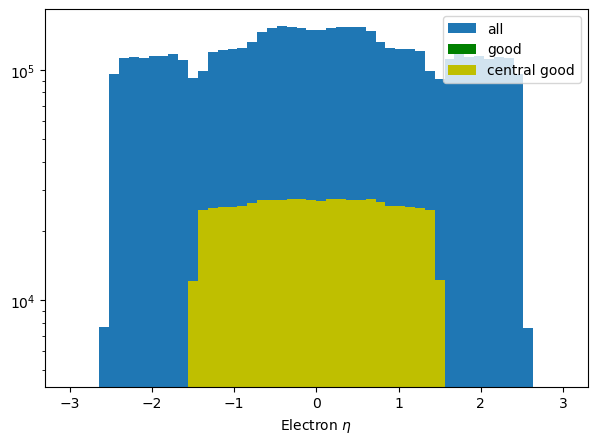

In [14]:
plt.hist(np_eta_all.flatten(), label='all', bins=50, range=(-3.0,3.0))
plt.hist(np_eta_good.flatten(), label='good', bins=50, range=(-3.0,3.0), color='g')
plt.hist(np_eta_central_good.flatten(), label='central good', bins=50, range=(-3.0,3.0), color='y')
plt.yscale('log')
plt.xlabel('Electron $\eta$')
plt.legend();

There isn't anything very magical occuring here: the function is called with an argument of whatever preceeds the filtering brackets. So `eles[central_good_ele]` is a short cut for `eles[central_good_ele(eles)]`. This is more about syntatic sugar.

## Cutting on numbers of objects

So far the selection and filtering has all been on a single object - like a single electron having $p_T > 50$ GeV. What if you want to require at least two electrons that satisfy that requirement? To count the number of objects that satisfy a requirement, after the cuts, add the `Count()` method. `Count` will always count the number of objects it is looking at! It can be used both to get back counts and also to filter:

In [15]:
%%time
electron_counts = make_local(eles.Count())
good_electron_counts = make_local(good_eles.Count())

Wall time: 2min 13s


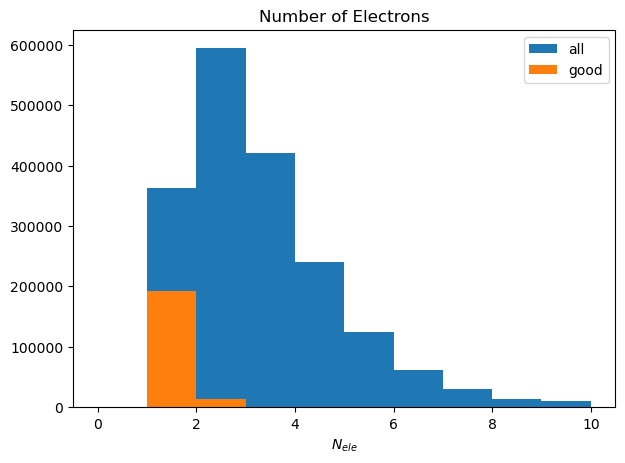

In [16]:
plt.hist(electron_counts[electron_counts>0], label='all', range=(0,10))
plt.hist(good_electron_counts[good_electron_counts>0], label='good', range=(0,10))
plt.xlabel('$N_{ele}$')
plt.title('Number of Electrons')
_ = plt.legend()

And we can also filter on number of electrons, creating a collection of events that have only two electrons:

In [17]:
%%time
good_events = df[eles.Count() == 2]
ele_per_event_count = make_local(good_events.Electrons("Electrons").Count())

Wall time: 1min 4s


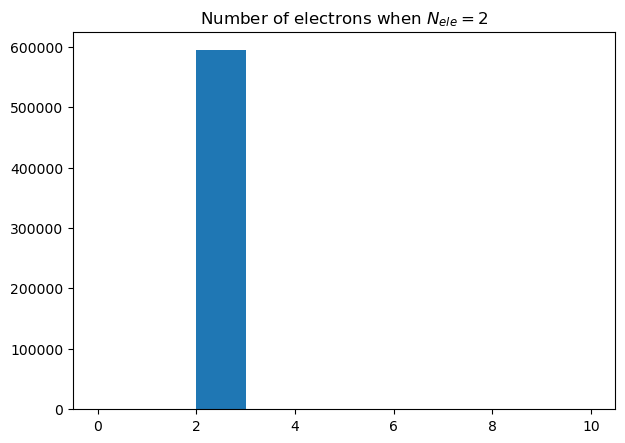

In [18]:
plt.hist(ele_per_event_count, range=(0,10))
_ = plt.title ('Number of electrons when $N_{ele} = 2$')